In [1]:
# !apt-get --assume-yes install libsndfile1

%load_ext autoreload
%autoreload 2

import gc
import os
import sys
from os.path import basename
from pathlib import Path
import glob
import math

import librosa
import librosa.display

import numpy as np
import pandas as pd

from itertools import product

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, matthews_corrcoef, f1_score
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
    GridSearchCV,
    StratifiedShuffleSplit
)

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from IPython.display import Image

from tensorflow.keras import backend as K
import tensorflow as tf

from xgboost import XGBClassifier

sys.path.append("../")

from helpers.assess import (
    make_classification_report,
    make_confusion_matrix,
    make_class_weight_dict,
    get_f1,
    make_notebook_classification_summary,
    make_notebook_undersampling_smote_classification_summary
)
from helpers.experiment import experiment
from helpers.split import make_train_test_split, tag_label_feature_split
from helpers.save import results

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

DATASET_FOLDER = "../datasets/"

# Dataset: MTG-Jamendo

Our project uses  the MTG-Jamendo dataset.
https://mtg.github.io/mtg-jamendo-dataset/

It is built using music available at Jamendo under Creative Commons licenses and tags provided by content uploaders. The dataset contains over 55,000 full audio tracks with 195 tags from genre, instrument, and mood/theme categories.

As we describe in greater detail in our report, we limit our analysis to songs that are identified as belonging to exactly one of ten genres (defined below).  We eliminate songs in other genres.  We also eliminate songs labeled as belonging to more than one of these 10 genres. This elimination has been performed outside this notebook and already removed from the `.pickle` files we load below. We also flattened array features into their own columns (with the exception of mel spectrograms--also discussed later) when creating the data files.

In [2]:
# Read the data set. The features we use are stored across two files for portability
df_all = pd.read_pickle(os.path.join(DATASET_FOLDER, "dataset_00_all.pickle"))
df_melspec = pd.read_pickle(os.path.join(DATASET_FOLDER, "dataset_10_melspecs.pickle"))

In [3]:
# sort so that genre at each index is same across both datasets (this will NOT guarantee alignment such that
# the features in the left set match to the exact song of the features in the right set, but because we don't
# use models that digest from both feature sets at once, this is O.K.)
def sort_by_sparse_genre(df):
    return df.sort_values(by=['genre_blues','genre_classical','genre_country','genre_disco','genre_hiphop','genre_jazz','genre_metal','genre_pop','genre_reggae','genre_rock'])
df_all = sort_by_sparse_genre(df_all)
df_melspec = sort_by_sparse_genre(df_melspec)

In [4]:
# Get labels, a label encoder and features using a utility function
# we wrote to separate labels and features from the MTG-Jamendo dataset
# and also to discard extraneous metadata.  The code for this function can
# be found in the helpers folder of the project repository.
_, (y_computed_true, le), X_computed = tag_label_feature_split(df_all, label_format="encoded")
_, (y_melspec_true, _), X_melspec = tag_label_feature_split(df_melspec, label_format="encoded")

In [5]:
# confirm that two datasets are aligned -- can share one "Y"
print(f'There are {len(y_computed_true[y_computed_true != y_melspec_true])} unmatched rows.')
y_true = y_computed_true
del y_computed_true
del y_melspec_true

There are 0 unmatched rows.


# Exploratory Data Analysis

In [6]:
# review the shapes
print(f"{X_computed.shape= } {y_true.shape= }")
print(f"Mel Spectrogram Shape: {X_melspec.iloc(0)[0][0].shape}")

X_computed.shape= (21351, 2654) y_true.shape= (21351,)
Mel Spectrogram Shape: (96, 683)


As mentioned above, the complete feature set comprises 2,654 computed features, and a single mel spectrogram contains 683 samples each sampled at 96 frequency centers adding up to 65,568 melspec features. This gives us an overal total of 68,222 features per song.

## Features

Machine learning work on audio typically relies on various features extracted from the underlying audio signal.  The signal processing involved is complex and a meaningful discussion is well beyond the scope of this project.

There are a few fundamental concepts that we want to touch on nevertheless.

We begin with spectrograms.  A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.  Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time. See [this article](https://pnsn.org/spectrograms/what-is-a-spectrogram) presented by the Pacific Northwest Seismic Network.  

Studies have shown that humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies. For example, we can easily tell the difference between 500 and 1000 Hz, but we will hardly be able to tell a difference between 10,000 and 10,500 Hz, even though the distance between the two pairs are the same.  In 1937, Stevens, Volkmann, and Newmann proposed a unit of pitch such that equal distances in pitch sounded equally distant to the listener. This is called the mel scale. We perform a mathematical operation on frequencies to convert them to the mel scale.  A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.  See [this article](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53) appearing on medium.com

So, it is most common today to start with the spectrogram representation of an audio signal and convert that to a spectrogram on the mel scale, a mel spectrogram.  Some models, like our CNN model, work directly from the mel spectrogram. In other cases, people derive useful features from the mel spectrogram.

### Let's look at some Mel Spectogram examples for different genres

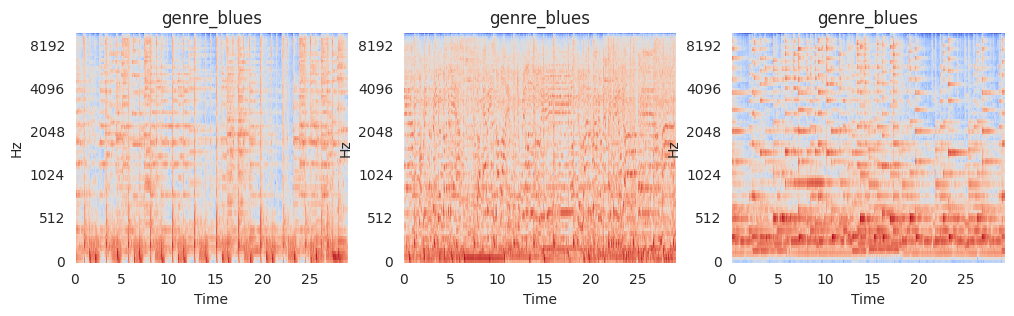

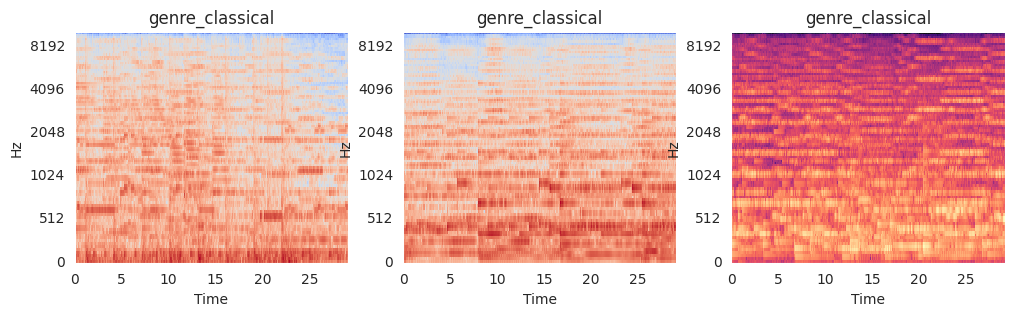

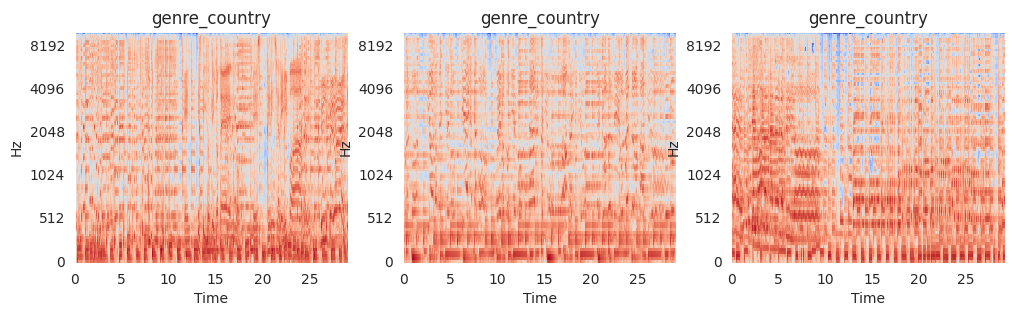

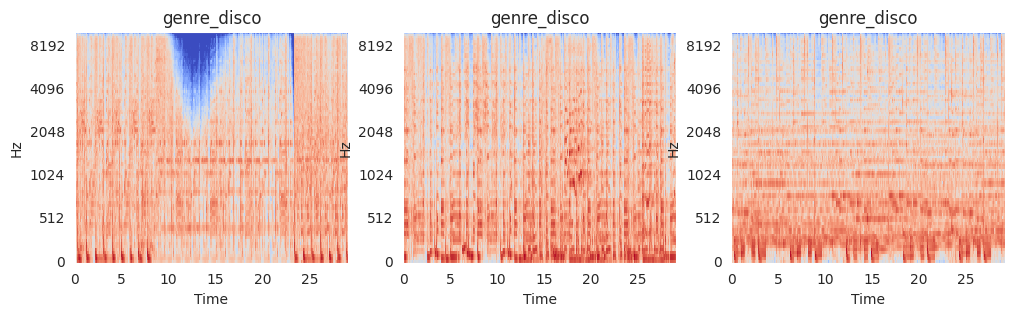

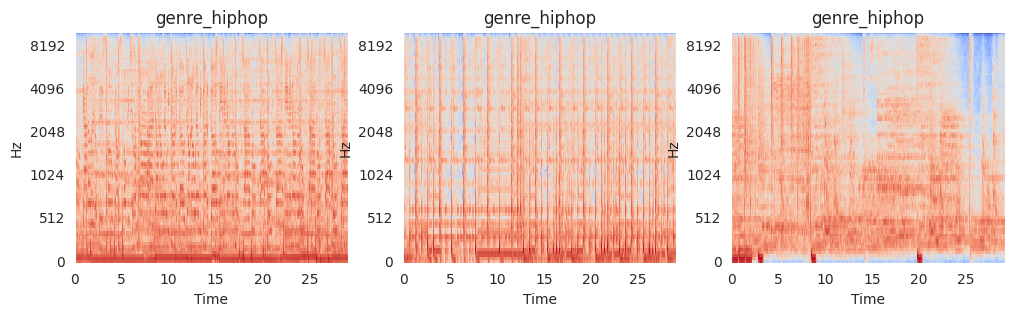

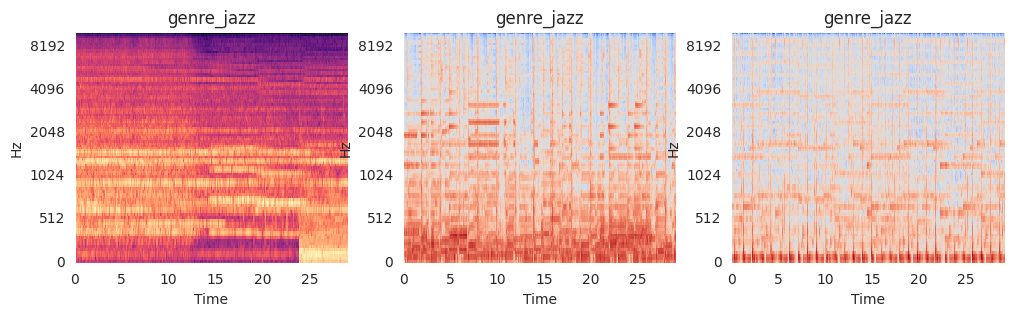

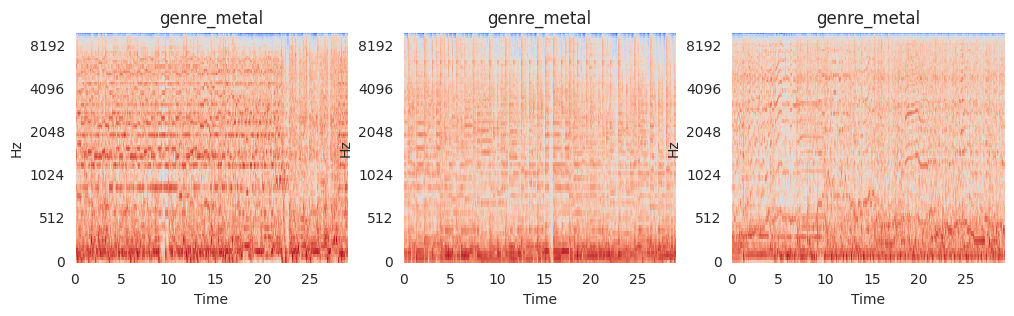

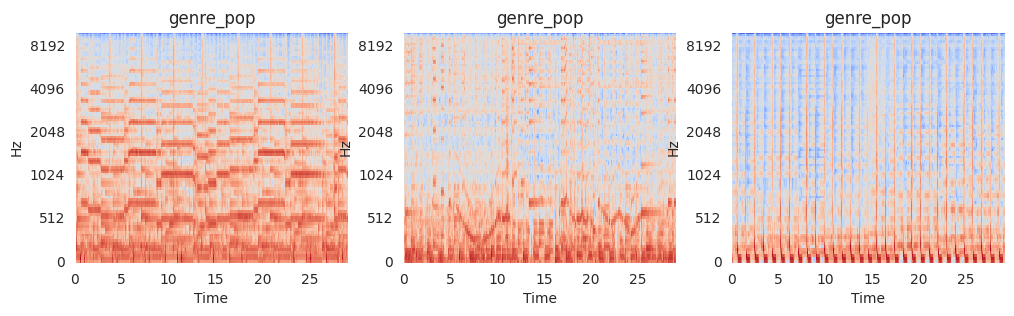

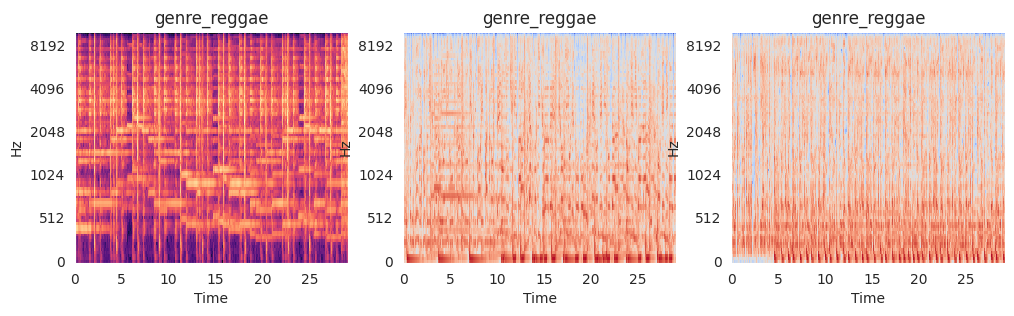

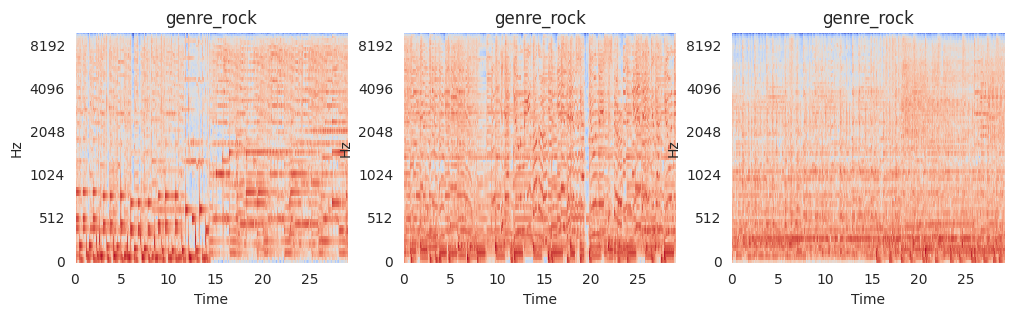

In [7]:
for l in range(10):
    nrows, ncols = 1, 3  # print first 4 images
    f, axs = plt.subplots(nrows, ncols, figsize=(12, 3))
    tempArr = X_melspec[y_true == l]
     
    label = le.inverse_transform([l])[0]
    num = 0
    for i in range(ncols):
        img = librosa.display.specshow(
            # double check this index
            tempArr.iloc(0)[i][0],
            x_axis="time",
            y_axis="mel",
            sr=12000,
            fmax=10000,
            ax=axs[i],
        )
        axs[i].set(title=label)
        num += 1
    plt.show()

### MFCC

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.  Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This very brief summary is based on [this summary](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) appearing on wikipedia.

Many music genre classification models rely to a large degree on MFCCs.  To that end, we paid attention to MFCC data available to us in the dataset.  In particular, the values of thirteen MFCC coefficients, as well as MFCC related variance, covariance and inverse covariance data points presented in the dataset.

### Interesting Features

We also ran a series of statistical tests to identify features in the dataset that appear to have statistically meaningful relationships to the various genres.  We then ranked their overall statistically meaningfulness by combining their ranking from individual genres. We identified the top ten features using a p-value driven approach:

![p-value ranking](./p_val.png)

## Genre Classes & Data Imbalance

In [8]:
# Review the mapping between genre_ids and the genres themselves.
genre_counts = pd.DataFrame(le.inverse_transform(y_true), columns=["genre"]).value_counts()
genre_counts = {k[0]:v for k,v in dict(genre_counts).items()}
print(f"Class ID  Genre Name  Sample Count\n--------  ----------  ------------")
for id, genre in enumerate(le.inverse_transform(range(10))):
    print(f"{id}         {genre[6:].ljust(10)}  {genre_counts[genre]}")

Class ID  Genre Name  Sample Count
--------  ----------  ------------
0         blues       468
1         classical   5276
2         country     409
3         disco       361
4         hiphop      2126
5         jazz        1552
6         metal       831
7         pop         5343
8         reggae      985
9         rock        4000


Our data is imbalanced.  The pop, classical and rock genres dominate the dataset.  At the other end of the spectrum, blues, country and disco are under represented.  We see this as an artifact of this particular data set only and not reflective of anything more.  Many of the models we worked with provide a parameter that takes into account class imbalance and weights accordingly based on inverse population proportion to enhance the significance of individual data points from under represented classes.  We utitilize that approach when we can.  In some cases, which we describe below, we look to other means to address the imbalance.

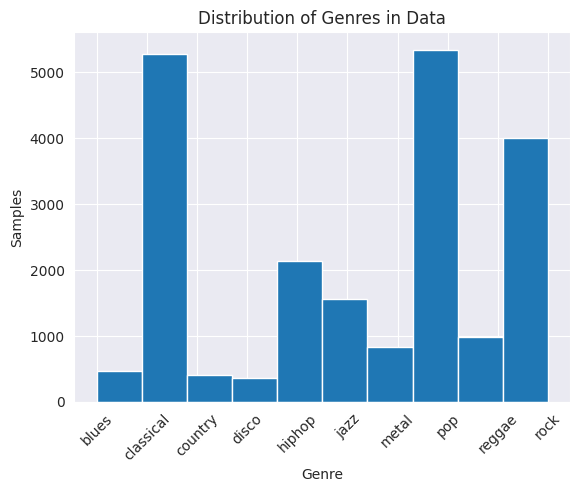

In [9]:
graph_genre_labels = [label[6:] for label in le.inverse_transform(range(10))]
plt.hist([y_true])
plt.title("Distribution of Genres in Data")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.xticks(range(10), graph_genre_labels, rotation=45)
plt.show()

# Preprocessing

### Data Splitting

We set aside 20% of our data for testing and use a stratified split, with shuffling, since we have a multi-class problem. 

In [10]:
# split the data for training and testing with shuffling and stratification
(
    X_computed_train_val, X_computed_test,
    X_melspec_train_val,  X_melspec_test,
    y_true_train_val,     y_true_test
) = train_test_split(
    X_computed, X_melspec, y_true, test_size=0.2, random_state=1962, shuffle=True, stratify=y_true
)

In [11]:
# review the shapes
print(f"{X_computed_train_val.shape = }\t{y_true_train_val.shape = }")
print(f"{X_computed_test.shape =  }\t{y_true_test.shape =  }")

X_computed_train_val.shape = (17080, 2654)	y_true_train_val.shape = (17080,)
X_computed_test.shape =  (4271, 2654)	y_true_test.shape =  (4271,)


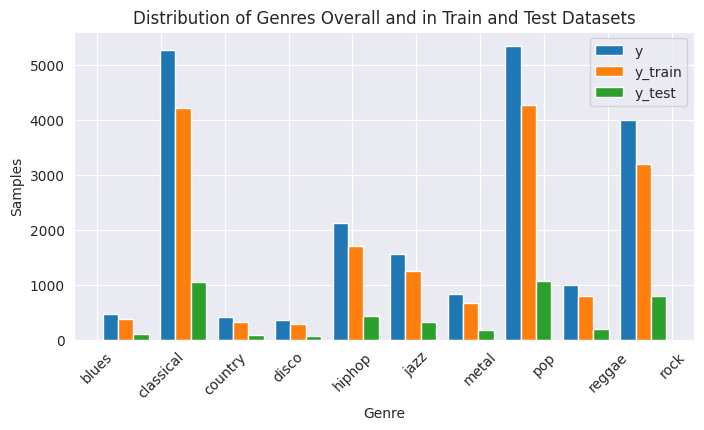

In [12]:
# reconfirm the distribution across the various sets
plt.figure(figsize=(8, 4))
plt.hist([y_true, y_true_train_val, y_true_test], label=["y", "y_train", "y_test"])
plt.xticks(range(10), graph_genre_labels, rotation=45)
plt.title("Distribution of Genres Overall and in Train and Test Datasets")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.legend()
plt.show()

### Standardization

While some models (such as extreme gradient boost) do not require feature scaling or standardization for best performance, most do.  Morever, principal component analysis and some SMOTE-related sampling approaches also benefit from feature scaling or standardization.  Therefore we apply standardization to our features as a general rule. 




  


In [13]:
scaler = StandardScaler()
X_computed_train_val_scaled = scaler.fit_transform(X_computed_train_val)
X_computed_test_scaled = scaler.transform(X_computed_test)

# Baseline Model

As the first experiment, we built a logistic regression model using all the features available to us along with very limited hyperparameter tuning on the L2 regularization strength (“C”). Based on what we learned in this course, we expected this model to not only perform poorly but also overfit given the number of features included in this model.

We trained our first model by grid-searching acorss 10 values of inverse regularization strengths chosen in a logarithmic scale between 1e-4 and 1e4.

![Regularization Strengths](../member_workspaces/lawrence/logistic_regression_naive_experiment.png)

As expected, as we decreased the regularization strength, our model immediately started to overfit. Even at the highest regularization strength of 0.0001 that we experimented with, our model performed abysmally, with a train MCC and a validation MCC of ~54.08% and ~50.95%, respectively

Given that our model overfitted the least at this regularization strength, we re-trained our model by including validation set in our training set and evaluated against the test set, yielding a train MCC and a test MCC of ~54.91% and ~51.78%, respectively.

The following is our first logistic regression model:

In [14]:
baseline_model = LogisticRegression(
        random_state = 1962, 
        C = 0.0001,
        max_iter=1000000,
        class_weight='balanced',
        n_jobs=-1
)

baseline_model.fit(X_computed_train_val_scaled, y_true_train_val)


LogisticRegression(C=0.0001, class_weight='balanced', max_iter=1000000,
                   n_jobs=-1, random_state=1962)

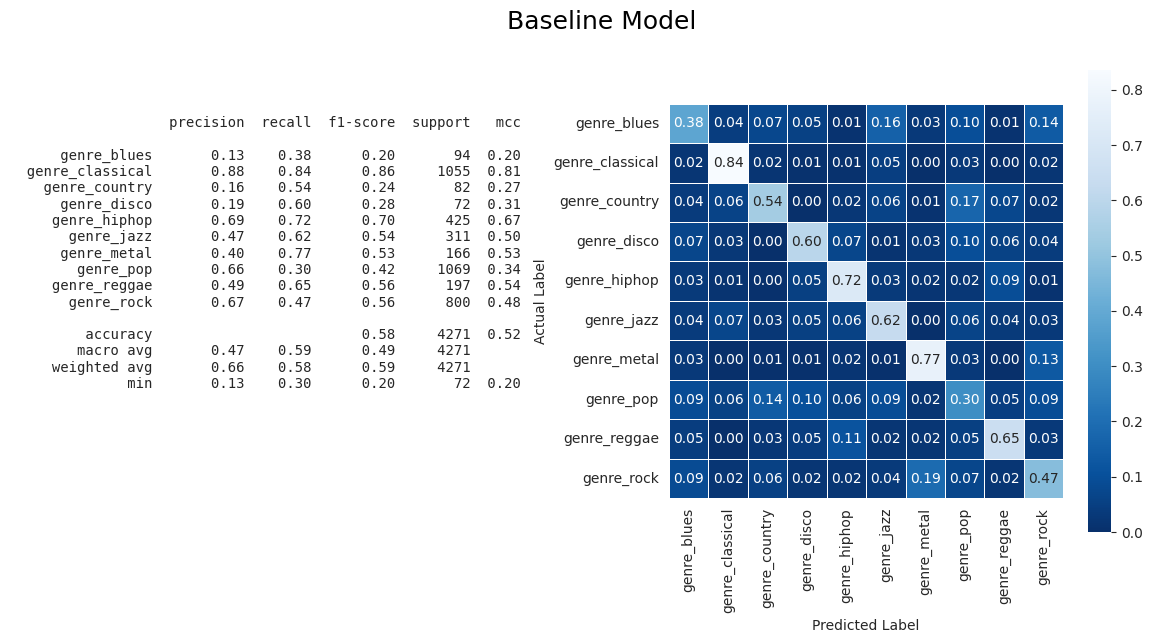

Test MCC: 0.5177517884527502
Test F1 Macro: 0.48764910333932143
Test Balanced Accuracy: 0.5890978613609682


In [66]:
baseline_model_y_pred_test = baseline_model.predict(X_computed_test_scaled)

baseline_regression_metrics = {
    'model_name': 'Baseline Logistic Regression',
    'test_mcc':matthews_corrcoef(y_true_test, baseline_model_y_pred_test),
    'test_f1_macro':f1_score(y_true_test, baseline_model_y_pred_test, average='macro'),
    'test_balanced_accuracy':balanced_accuracy_score(y_true_test, baseline_model_y_pred_test)
}

baseline_regression_classification_report = make_classification_report(
    y_true_test, baseline_model_y_pred_test, label_encoder=le, print_report=False
)

make_notebook_classification_summary(y_true_test, baseline_model_y_pred_test, le=le, title="Baseline Model")

print(f"Test MCC: {baseline_regression_metrics['test_mcc']}")
print(f"Test F1 Macro: {baseline_regression_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {baseline_regression_metrics['test_balanced_accuracy']}")
pass

Judging by the test MCCs and the accuracies, we observed that our naive model performed the best at identifying the classical genre and the worst at identifying the blues genre, with test MCCs of ~0.20 and 0.81, respectively. One notable observation was that our naive model performed quite poorly in identifying the pop genre, which was the majority class in our dataset.

# Principal Component Analysis

With so many features and classes, we struggled to visualize our data before building our models.  We found that principal component analysis gave us a perspective on the richness and complexity of our data.

The following two dimensional scatter plot shows our dataset viewed through the lens of just the first two principal components.  While some genres appear to be more readily discernible, others are not.  Separating out this dataset has been challenging and this plot starts to give us a sense of why.

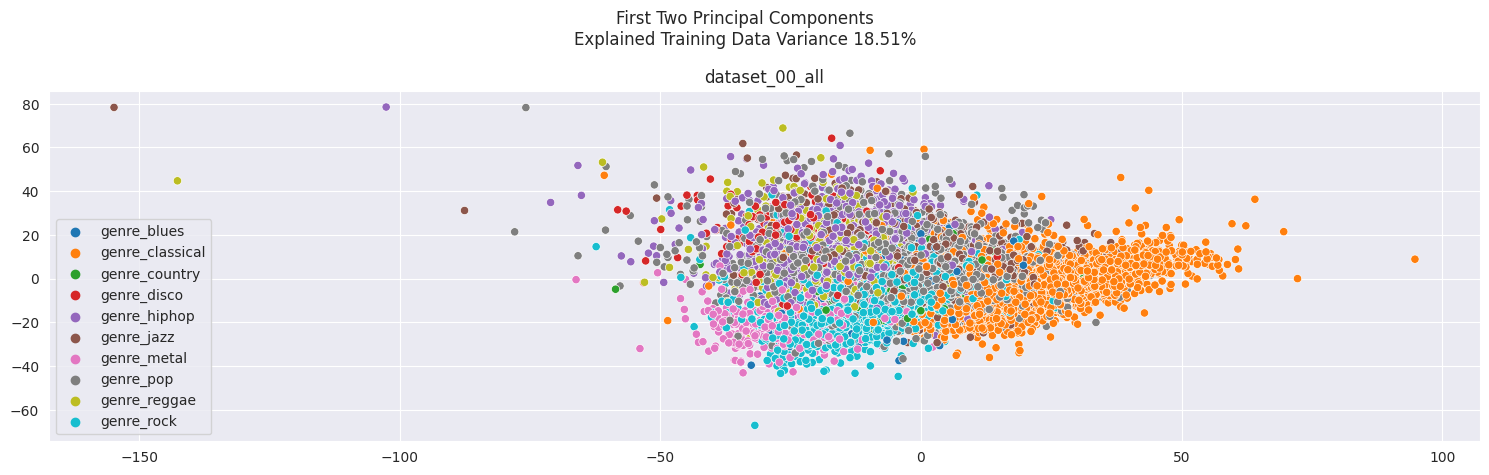

In [16]:
pca_2 = PCA(n_components=2)

# Fit PCA with training features only

X_computed_train_val_pca_2 = pca_2.fit_transform(X_computed_train_val_scaled)
X_computed_test_pca_2 = pca_2.transform(X_computed_test_scaled)

# Concatenate test and train data for visualization only

X_pca_2 = np.concatenate((X_computed_train_val_pca_2, X_computed_test_pca_2), axis=0)
y_pca_2 = np.concatenate((y_true_train_val, y_true_test), axis=0)

explanation_ratio = round(sum(pca_2.explained_variance_ratio_[0:2]) * 100, 2)

fig, ax_2d = plt.subplots(figsize=(15, 4.8))
fig.suptitle(
    f"First Two Principal Components\nExplained Training Data Variance {explanation_ratio}%"
)

hue_order = list(le.inverse_transform(range(10)))

sns.scatterplot(
    x=X_pca_2[:, 0],
    y=X_pca_2[:, 1],
    hue=le.inverse_transform(y_pca_2),
    hue_order=hue_order,
    ax=ax_2d,
    cmap=cmap,
).set(title=basename("dataset_00_all"))


plt.tight_layout()
plt.show()
fig.savefig("pca-slide-2.png")

We wanted to see if adding a third component to the mix might make it easier to separate our classes.  The following three dimensional scatterplot was the result.  Again, this is on our all features dataset.  When we applied this methodology to other renditions of our dataset we did not see anything meaningfully different.  In some cases the data looked reasonably similar to the plot we show below.  In other cases, the data was even more condensed.

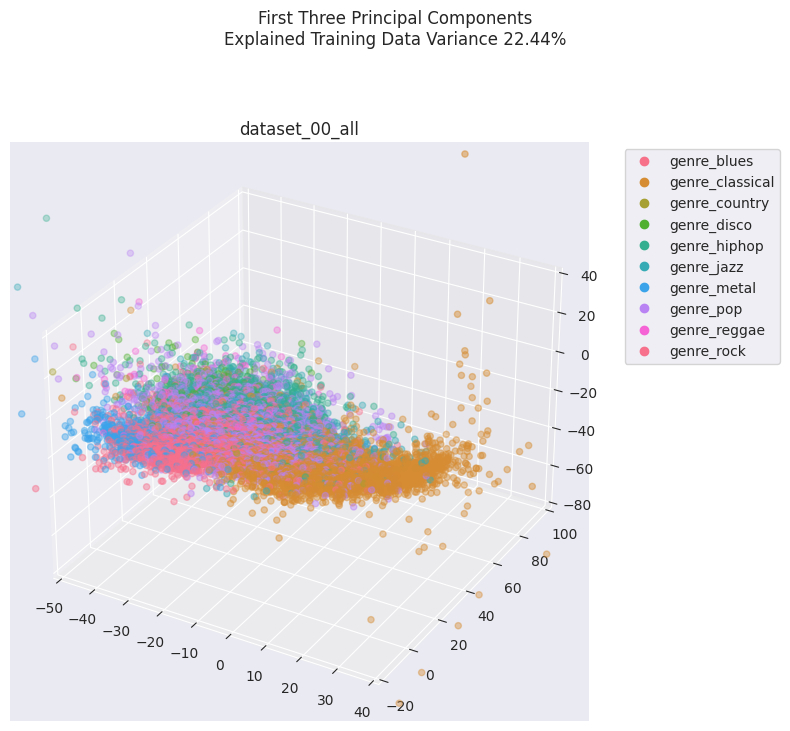

In [17]:
pca_3 = PCA(n_components=3)

# Fit PCA with training features only

X_computed_train_val_pca_3 = pca_3.fit_transform(X_computed_train_val_scaled)
X_computed_test_pca_3 = pca_3.transform(X_computed_test_scaled)

# Concatenate test and train data for visualization only

X_pca_3 = np.concatenate((X_computed_train_val_pca_3, X_computed_test_pca_3), axis=0)
y_pca_3 = np.concatenate((y_true_train_val, y_true_test), axis=0)

explanation_ratio = round(sum(pca_3.explained_variance_ratio_[0:3]) * 100, 2)


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

fig.suptitle(
    f"First Three Principal Components\nExplained Training Data Variance {explanation_ratio}%"
)

pca_3_1 = X_pca_3[:, 0]
pca_3_2 = X_pca_3[:, 1]
pca_3_3 = X_pca_3[:, 2]

scatter = ax.scatter(pca_3_1, pca_3_2, pca_3_3, c=y_pca_3, cmap=cmap)
plt.legend(
    scatter.legend_elements()[0],
    list(le.inverse_transform(range(10))),
    bbox_to_anchor=(1.05, 1),
    loc=2,
)

ax.set_title(basename("dataset_00_all"))
ax.set_xlim(-50, 40)
ax.set_ylim(-20, 100)
ax.set_zlim(-80, 40)
plt.tight_layout()
plt.show()
fig.savefig("pca-slide-3.png")

When we work with principal component analysis or SMOTE and SMOTE-related sampling we extended the pre-processing pipeline beyond standardization as the situation warranted.  Our approach to principal component analysis is to use a sufficient number of components to capture 95% of the variance in the underlying data.

As shown below, we are able to capture 95% of the variance in our all features dataset with 387 principal components, a meaningful reduction from the 2,654 components presented in the dataset originally. We will make further use of principal component analysis to visualize our data in the exploratory data analysis included below.

In [18]:
pca = PCA(random_state=1962, n_components=0.95)
X_computed_train_val_pca = pca.fit_transform(X_computed_train_val_scaled)
X_computed_test_pca = pca.transform(X_computed_test_scaled)

X_computed_train_val_scaled.shape = (17080, 2654)	y_true_train_val.shape = (17080,)
X_computed_test_scaled.shape  =  (4271, 2654)	 y_true_test.shape =  (4271,)
X_computed_train_val_pca.shape    = (17080, 387)	y_true_train_val.shape = (17080,)
X_computed_test_pca.shape     =  (4271, 387) 	 y_true_test.shape =  (4271,)


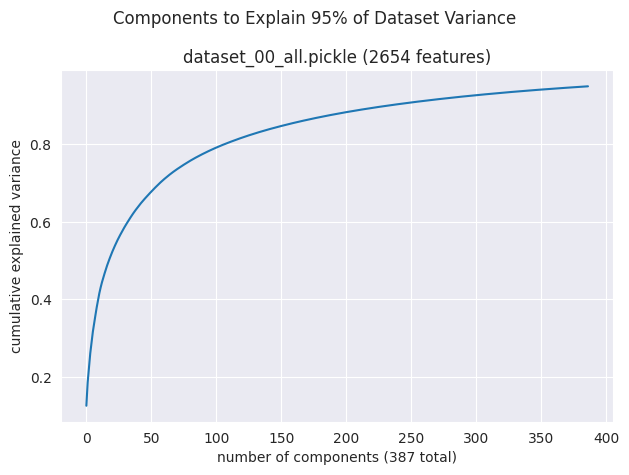

In [19]:
# review the shapes
print(f"{X_computed_train_val_scaled.shape = }\t{y_true_train_val.shape = }")
print(f"{X_computed_test_scaled.shape  =  }\t {y_true_test.shape =  }")
print(f"{X_computed_train_val_pca.shape    = }\t{y_true_train_val.shape = }")
print(f"{X_computed_test_pca.shape     =  } \t {y_true_test.shape =  }")

dataset = "../../datasets/dataset_00_all.pickle"
fig, ax = plt.subplots()
fig.suptitle("Components to Explain 95% of Dataset Variance")

original_features = X_computed_train_val.shape[1]

ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_title(f"{basename(dataset)} ({original_features} features)")
ax.set(
    xlabel=f"number of components ({pca.components_.shape[0]} total)",
    ylabel="cumulative explained variance",
)

plt.tight_layout()
plt.show()
fig.savefig("pca-slide-1.png")

## Improving our baseline with feature reduction

After learning that our first logistic regression model overfitted, we experimented with select K best, random forest and PCA in attempt to reduce the complexity of our next model. We treated the following as hyperparamters for tuning: (a) number of features and dimensions used by these automatic feature selection and dimensionality reduction and (b) inverse regularization strength used by logistic regression. We trained our models by grid-searching through our hyperparameter space, including the number of features and dimensions from 50 to 800 at intervals of 50 as well as inverse regularization strengths of 10 values chosen in a logarithmic scale between 1e-4 and 1e4. 

We wanted to investigate the impact of regularization strength across the three algorithms on the performance of a model. In the illustration below, we set the number of features for each of the algorithms to 400 while varying the inverse regularization strength:

 ![Feature Improvement](../member_workspaces/lawrence/logistic_regression_gridsearch_c.png)
 
 Based on the above, we confirmed our understanding that, as we decrease the regularization strength, our models would become more prone to overfitting. The key takeaway is that there is no one-size-fits-all regularization strength that we could apply to all our experiments.

We also wanted to investigate the impact of the number of features and dimensions on the performance of a model across all three techniques. In the illustration below, we imposed a very low regularization strength on our models, with an inverse of regularization strength of 10,000 while varying the number of features for each of the algorithms.

![Feature Improvement](../member_workspaces/lawrence/logistic_regression_gridsearch_n.png)

As expected, given the low regularization strength, all our models overfitted. We confirmed our understanding that, as we increased the number of features and dimensions, our models would become more prone to overfitting. The key takeaway was that we should expect overfitting to occur as we increased the number of features and dimensions and we wanted to make sure that we compensate for such overfitting by imposing higher regularization strength accordingly.

#### Tuned logistic regression model

After grid-searching through our hyperparameters space, the best performing logistic regression model iteration used (a) 400 most important features from a Random Forest classifier as trained with a max tree depth of 500 and (b) an inverse regularization strength of 2.7826. The original model iteration achieved a train MCC and a validation MCC of 66.48% and 57.51%, respectively. We retrained our final model by including the validation set as part of the training set and achieved a train MCC and a validation MCC of 64.99% and 57.58%, respectively.

The following is the final model:

In [20]:
# train random forest classifier

baseline_forest_classifier = RandomForestClassifier(n_estimators=100, 
                             max_depth=500, 
                             random_state=10)
baseline_forest_classifier.fit(X_computed_train_val_scaled, y_true_train_val)

RandomForestClassifier(max_depth=500, random_state=10)

In [21]:
# only use the top 400 most important features

top_n = 400
df_feature_importance = pd.DataFrame({"feature_name": X_computed.columns, 
                                      "feature_importance": baseline_forest_classifier.feature_importances_})
df_feature_importance.sort_values(by="feature_importance", ascending=False, inplace=True)

top_features = df_feature_importance.head(top_n)['feature_name'].unique()
feature_indices = [list(X_computed.columns).index(f) for f in top_features]

X_computed_train_val_scaled_reduced = X_computed_train_val_scaled[:, feature_indices]
X_computed_test_scaled_reduced = X_computed_test_scaled[:, feature_indices]


In [22]:

# train model

tuned_baseline_model = LogisticRegression(
    random_state = 1962, 
    C = 2.7826,
    max_iter=1000000,
    class_weight='balanced',
    n_jobs=-1
)
tuned_baseline_model.fit(X_computed_train_val_scaled_reduced, y_true_train_val)


LogisticRegression(C=2.7826, class_weight='balanced', max_iter=1000000,
                   n_jobs=-1, random_state=1962)

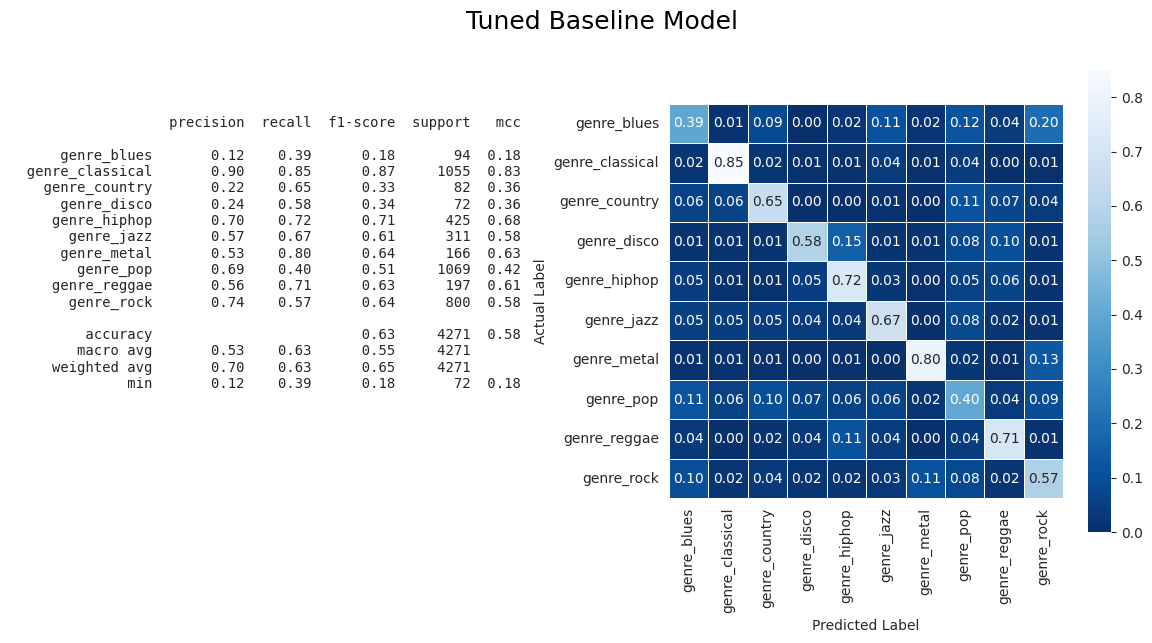

Tuned Baseline Performance:
--------------------------
Test MCC: 0.5758427113245448
Test F1 Macro: 0.5465171821083723
Test Balanced Accuracy: 0.6345280026868385

(Initial Baseline Performance again for reference):
--------------------------------------------------
Test MCC: 0.5177517884527502
Test F1 Macro: 0.48764910333932143
Test Balanced Accuracy: 0.5890978613609682


In [67]:
tuned_baseline_model_y_pred_test = tuned_baseline_model.predict(X_computed_test_scaled_reduced)

tuned_baseline_regression_metrics = {
    'model_name': 'Tuned Logistic Regression',
    'test_mcc':matthews_corrcoef(y_true_test, tuned_baseline_model_y_pred_test),
    'test_f1_macro':f1_score(y_true_test, tuned_baseline_model_y_pred_test, average='macro'),
    'test_balanced_accuracy':balanced_accuracy_score(y_true_test, tuned_baseline_model_y_pred_test)
}

tuned_baseline_regression_classification_report = make_classification_report(
    y_true_test, tuned_baseline_model_y_pred_test, label_encoder=le, print_report=False, digits=2
)

make_notebook_classification_summary(y_true_test, tuned_baseline_model_y_pred_test, le=le, title="Tuned Baseline Model")

print('Tuned Baseline Performance:')
print('--------------------------')
print(f"Test MCC: {tuned_baseline_regression_metrics['test_mcc']}")
print(f"Test F1 Macro: {tuned_baseline_regression_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {tuned_baseline_regression_metrics['test_balanced_accuracy']}")

print('\n(Initial Baseline Performance again for reference):')
print('--------------------------------------------------')
print(f"Test MCC: {baseline_regression_metrics['test_mcc']}")
print(f"Test F1 Macro: {baseline_regression_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {baseline_regression_metrics['test_balanced_accuracy']}")
pass

By comparing the final model against the naive model, the balanced accuracy improves by about 5%, and MCC by ~0.06. The final model outperformed the naive model at identifying most of the genres in the ~0.01-0.10 (MCC). However, the final model performed worse than the naive model at identifying the blues genre by ~0.01 in test MCC. It would appear that we sacrificed the performance for the blues genre in favor of the rest of the genres in our final model to achieve a higher overall test MCC.

## Researching PCA effects on SVM

We also created a support vector machine model (SVM), given the strong results from existing literature. The data used was pre-processed in the same manner as the prior models. We do not attempt to address sample imbalance by undersampling or oversampling.

The SVM is a prime candidate for pattern classification as well as nonlinear regression. Essentially, the main idea of SVM is to construct a hyperplane that acts as the decision surface such that the margin of separation between positive and negative samples is maximized.

We explore hyperparameter tuning by leveraging GridSearch.

In [24]:
def calc_gridsearch_params(X_train_pca, y_train):
    param_grid = [
     {'C': [1, 10, 100, 1000],
      'gamma': [0.001, 0.0001],
      'kernel': ['rbf'],
      'class_weight': ['balanced'],
      'random_state': [1962]
     }]

    pca_tuned_classifier = GridSearchCV(SVC(), param_grid, scoring='matthews_corrcoef', n_jobs=-1, verbose=2)
    pca_tuned_classifier.fit(X_train_pca, y_train)

    print(pca_tuned_classifier.best_params_)


In [25]:
def run_svm_model(X_train_val,y_true_train_val,X_test,y_true_test,C,gamma):
    classifier = SVC(
        C=100,
        gamma=.001,
        class_weight='balanced',
        random_state=1962
    )
    scoring = ['matthews_corrcoef', 'f1_macro', 'balanced_accuracy']
    scores = cross_validate (
        classifier, 
        X_train_val, 
        y=y_true_train_val, 
        scoring=scoring, 
        return_train_score=True, 
        return_estimator=True,
        n_jobs=-1
    )

    test_mcc = []
    test_f1 = []
    test_balanced_accuracy = []

    for classifier in scores['estimator']:
        predictions = classifier.predict(X_test)
        test_mcc.append (matthews_corrcoef (y_true_test, predictions))
        test_f1.append  (f1_score (y_true_test, predictions, average='macro'))
        test_balanced_accuracy.append (balanced_accuracy_score(y_true_test, predictions))
        
    metrics = {
        'test_mcc':np.mean(test_mcc),
        'test_f1_macro':np.mean(test_f1),
        'test_balanced_accuracy':np.mean(test_balanced_accuracy)
    }

    # get the classifier from the group with the highest mcc
    idx=np.argmax(scores['test_matthews_corrcoef'])
    best_classifier = scores['estimator'][idx]
    best_classifier_predictions = best_classifier.predict(X_test)
    
    return best_classifier_predictions,metrics


### GridSearch Tuned SVC Classifier No PCA

In [26]:
# calc_gridsearch_params(X_computed_train_val_scaled, y_true_train_val)

#### Gridsearch returns the following parameters: C=100, gamma=.001

In [27]:
svc_no_pca_y_pred_test, svc_no_pca_metrics = run_svm_model(
    X_computed_train_val_scaled,y_true_train_val,
    X_computed_test_scaled,y_true_test,100,0.001
)

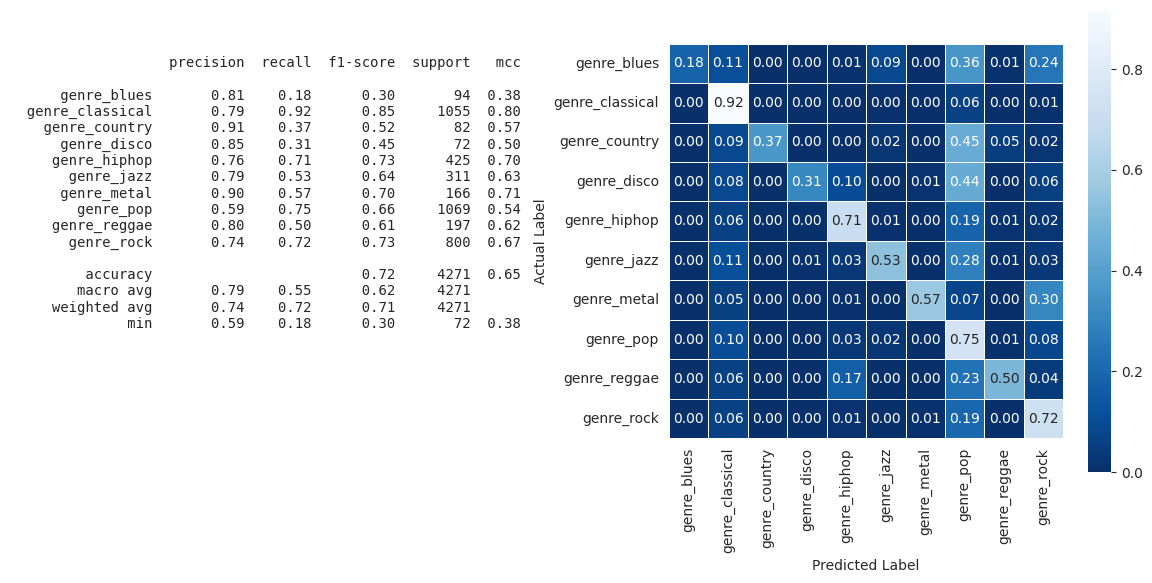


No-PCA SVC Performance:
-------------------------------------------------------
Test MCC: 0.6529688340989124
Test F1 Macro: 0.6168452958071258
Test Balanced Accuracy: 0.5524799669891362


In [28]:
svc_no_pca_metrics['model_name'] = 'SVM No PCA'
make_notebook_classification_summary(y_true_test,svc_no_pca_y_pred_test,le=le)

print('\nNo-PCA SVC Performance:')
print('-------------------------------------------------------')
print(f"Test MCC: {svc_no_pca_metrics['test_mcc']}")
print(f"Test F1 Macro: {svc_no_pca_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {svc_no_pca_metrics['test_balanced_accuracy']}")

### GridSearch Tuned SVC Classifier with PCA

In [29]:
# calc_gridsearch_params(X_computed_train_val_pca, y_true_train_val)

#### Gridsearch returns the following parameters: C=100, gamma=.001

In [30]:
svc_pca_y_pred_test, svc_pca_metrics = run_svm_model(
    X_computed_train_val_pca,y_true_train_val,
    X_computed_test_pca,y_true_test,100,0.001
)

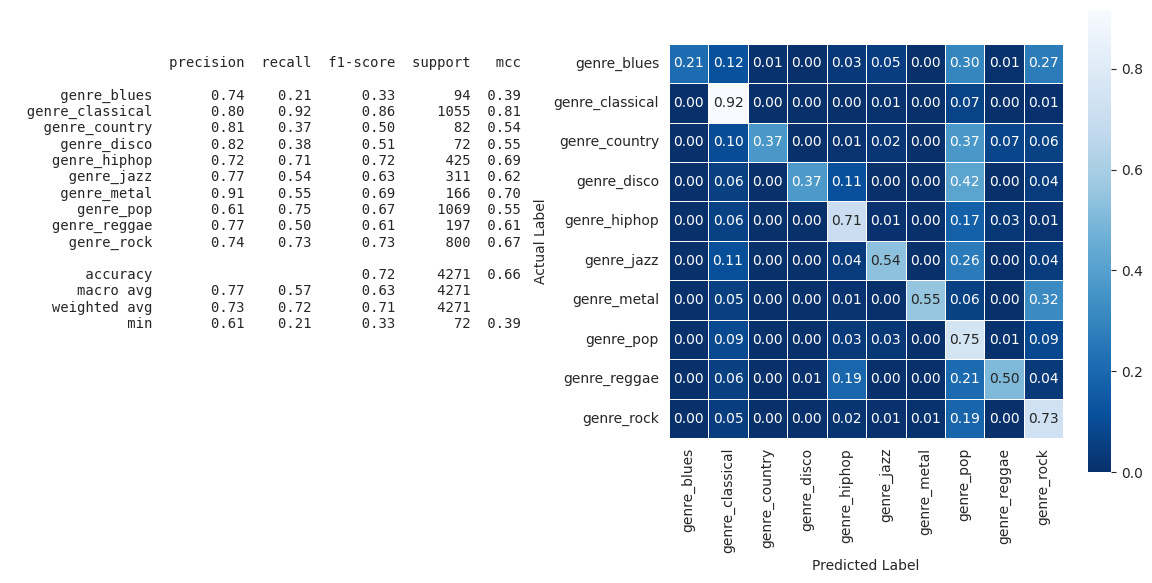


PCA SVC Performance:
-------------------------------------------------------
Test MCC: 0.6573261031089146
Test F1 Macro: 0.6249384461361914
Test Balanced Accuracy: 0.5632563379340205

(Initial Non-PCA SVC Performance again for reference):
-------------------------------------------------------
Test MCC: 0.6529688340989124
Test F1 Macro: 0.6168452958071258
Test Balanced Accuracy: 0.5524799669891362


In [31]:
svc_pca_metrics['model_name'] = 'SVM with PCA'
make_notebook_classification_summary(y_true_test,svc_pca_y_pred_test,le=le)

print('\nPCA SVC Performance:')
print('-------------------------------------------------------')
print(f"Test MCC: {svc_pca_metrics['test_mcc']}")
print(f"Test F1 Macro: {svc_pca_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {svc_pca_metrics['test_balanced_accuracy']}")

print('\n(Initial Non-PCA SVC Performance again for reference):')
print('-------------------------------------------------------')
print(f"Test MCC: {svc_no_pca_metrics['test_mcc']}")
print(f"Test F1 Macro: {svc_no_pca_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {svc_no_pca_metrics['test_balanced_accuracy']}")

We observed that GridSearch is very resource intensive. The GridSearch on our simpler non-PCA model ran for almost 6 hours in our machine. In contrast, after performing PCA, even though we were getting similar performance, our model ran much faster. This speaks to the significance of PCA in GridSearch as in the real world, models are often much more complex and being able to save on time and resources will be the determining factor in whether you have enough time to hypertune your model.

SVM shows a roughly an 8% drop in balanced accuracy relative to the tuned logistic regression model. There was a 0.14 MCC gain relative to our baseline logistic regression model, and 0.08 MCC gain relative to our tuned logistic regression model.

# Approaches for Data Imbalance

### Undersampling
Our simplest approach to addressing the imbalance was to undersample the training data. In This experiment we truncate the number of samples in each genre to the number of rows in our least represented genre.

In [32]:
# split train/validation into train and test datasets
(
    X_computed_train_scaled,
    X_computed_val_scaled,
    y_true_train,
    y_true_val
) = train_test_split(
    X_computed_train_val_scaled,y_true_train_val,
    test_size=0.25, shuffle=True, stratify=y_true_train_val, random_state=1962
)

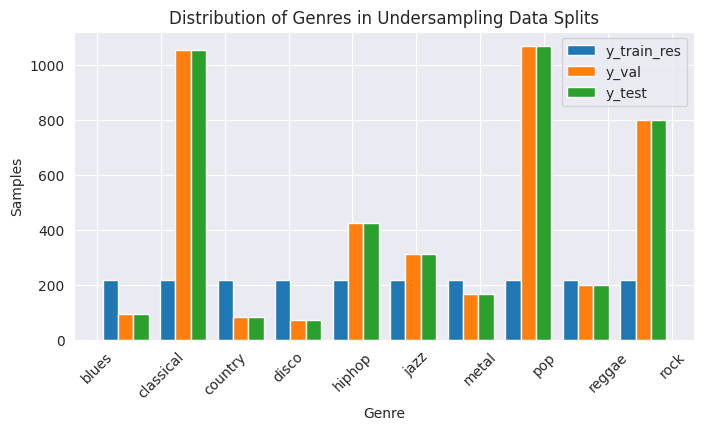

In [33]:

# undersample the train set to create balance
rus = RandomUnderSampler(random_state=1962)
X_computed_train_scaled_res, y_true_train_res = rus.fit_resample(X_computed_train_scaled, y_true_train)
# confirm the number of samples of each class
np.unique(y_true_train_res, return_counts=True)

# x_labels = [label[6:] for label in le.inverse_transform(range(class_count))]
plt.figure(figsize=(8,4))
plt.hist([y_true_train_res, y_true_val, y_true_test], label=['y_train_res', 'y_val', 'y_test'])
plt.xticks(range(len(le.classes_)), graph_genre_labels, rotation=45)
plt.title("Distribution of Genres in Undersampling Data Splits")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.legend()
plt.show()

### SMOTE
Our second approach to the imbalance is by applying Synthetic Minority Oversampling Technique (SMOTE) to generate new instances from existing minority classes. The synthesis of new data rows is only performed on the training data. The rows in validation and testing sets continue to only be ones in the original data set.

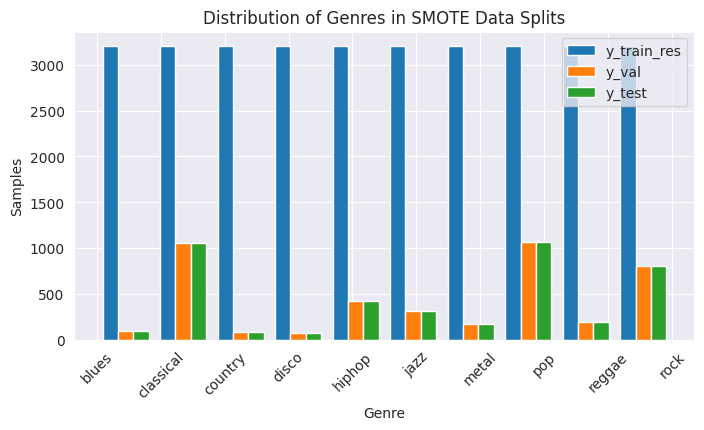

In [34]:
smt = SMOTE(random_state=1962)
X_computed_train_scaled_smt, y_true_train_smt = smt.fit_resample(X_computed_train_scaled, y_true_train)

# confirm the number of samples of each class
np.unique(y_true_train_smt, return_counts=True)

plt.figure(figsize=(8,4))
plt.hist([y_true_train_smt, y_true_val, y_true_test], label=['y_train_res', 'y_val', 'y_test'])
plt.xticks(range(len(le.classes_)), graph_genre_labels, rotation=45)
plt.title("Distribution of Genres in SMOTE Data Splits")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.legend()
plt.show()

## Comparing Imbalance Approaches using Extreme Gradient Boost

Unlike many models available to us, the Extreme Gradient Boost software we had does not include a way to specify that class imbalance should be handled by supplying class weights.  Weighting is available for binary classifiers but not for imbalanced data sets involving more than two classes.

We began with a default extreme gradient boost model and ran it against our collection of imbalanced datasets, both with and without principal component analysis. The results were very disappointing in all circumstances. That is not surprising as we made no attempt to deal with the imbalance in our dataset

Extreme Gradient Boost has a relatively complex set of hyperparamters.  Using gridsearch to explore the hyperparamter space in a brute force fashion is very inefficient.  So, we turned to a Bayesian Optimization package.

>Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not.  The package, with documentation and examples is maintained [here](https://github.com/fmfn/BayesianOptimization).

The hyerparameters we use in our models result from the use of the Bayesian optimization process.  We ended up tuning most of the model parameters away from their defaults, including L1 regularization. L2 regularization changes did not have a meaningful impact. We also made use of early stopping to limit overfitting.

In [35]:
# build and train the model
undersample_classifier = XGBClassifier(
    learning_rate=0.103897,
    n_estimators=828,
    max_depth=4,
    gamma=.00835,
    reg_alpha=3.834036,
    use_label_encoder=False,
    tree_method="gpu_hist",
    sampling_method="gradient_based",
    objective="multi:softprob",
    eval_metric=["mlogloss", "auc"], 
    early_stopping_rounds=5,
    seed=1962,
)

undersample_classifier.fit(
    X_computed_train_scaled_res,y_true_train_res,
    eval_set=[
        (X_computed_train_scaled_res, y_true_train_res),
        (X_computed_val_scaled, y_true_val)
    ], verbose=False
)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=['mlogloss', 'auc'], gamma=0.00835, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.103897, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=828, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=1962,
              reg_alpha=3.834036, ...)

In [36]:
smote_classifier = XGBClassifier(
    learning_rate= 0.080805,
    n_estimators=423,
    max_depth=8,
    gamma=.0513676,
    reg_alpha=8.308685,
    use_label_encoder=False,
    tree_method="gpu_hist",
    sampling_method="gradient_based",
    objective="multi:softprob",
    eval_metric=["mlogloss", "auc"], 
    early_stopping_rounds=10,
    seed=1962,
)

smote_classifier.fit(
    X_computed_train_scaled_smt, y_true_train_smt,
    eval_set=[
        (X_computed_train_scaled_smt, y_true_train_smt),
        (X_computed_val_scaled, y_true_val)
    ], verbose=False
)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['mlogloss', 'auc'], gamma=0.0513676, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.080805, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=423, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=1962,
              reg_alpha=8.308685, ...)

In [37]:
undersample_classifier_results = undersample_classifier.evals_result()
undersample_train_results=undersample_classifier_results['validation_0']
undersample_validation_results=undersample_classifier_results['validation_1']
undersample_classifier_y_pred_test=undersample_classifier.predict(X_computed_test_scaled)

smote_classifier_results = smote_classifier.evals_result()
smote_train_results=smote_classifier_results['validation_0']
smote_validation_results=smote_classifier_results['validation_1']
smote_classifier_y_pred_test=smote_classifier.predict(X_computed_test_scaled)

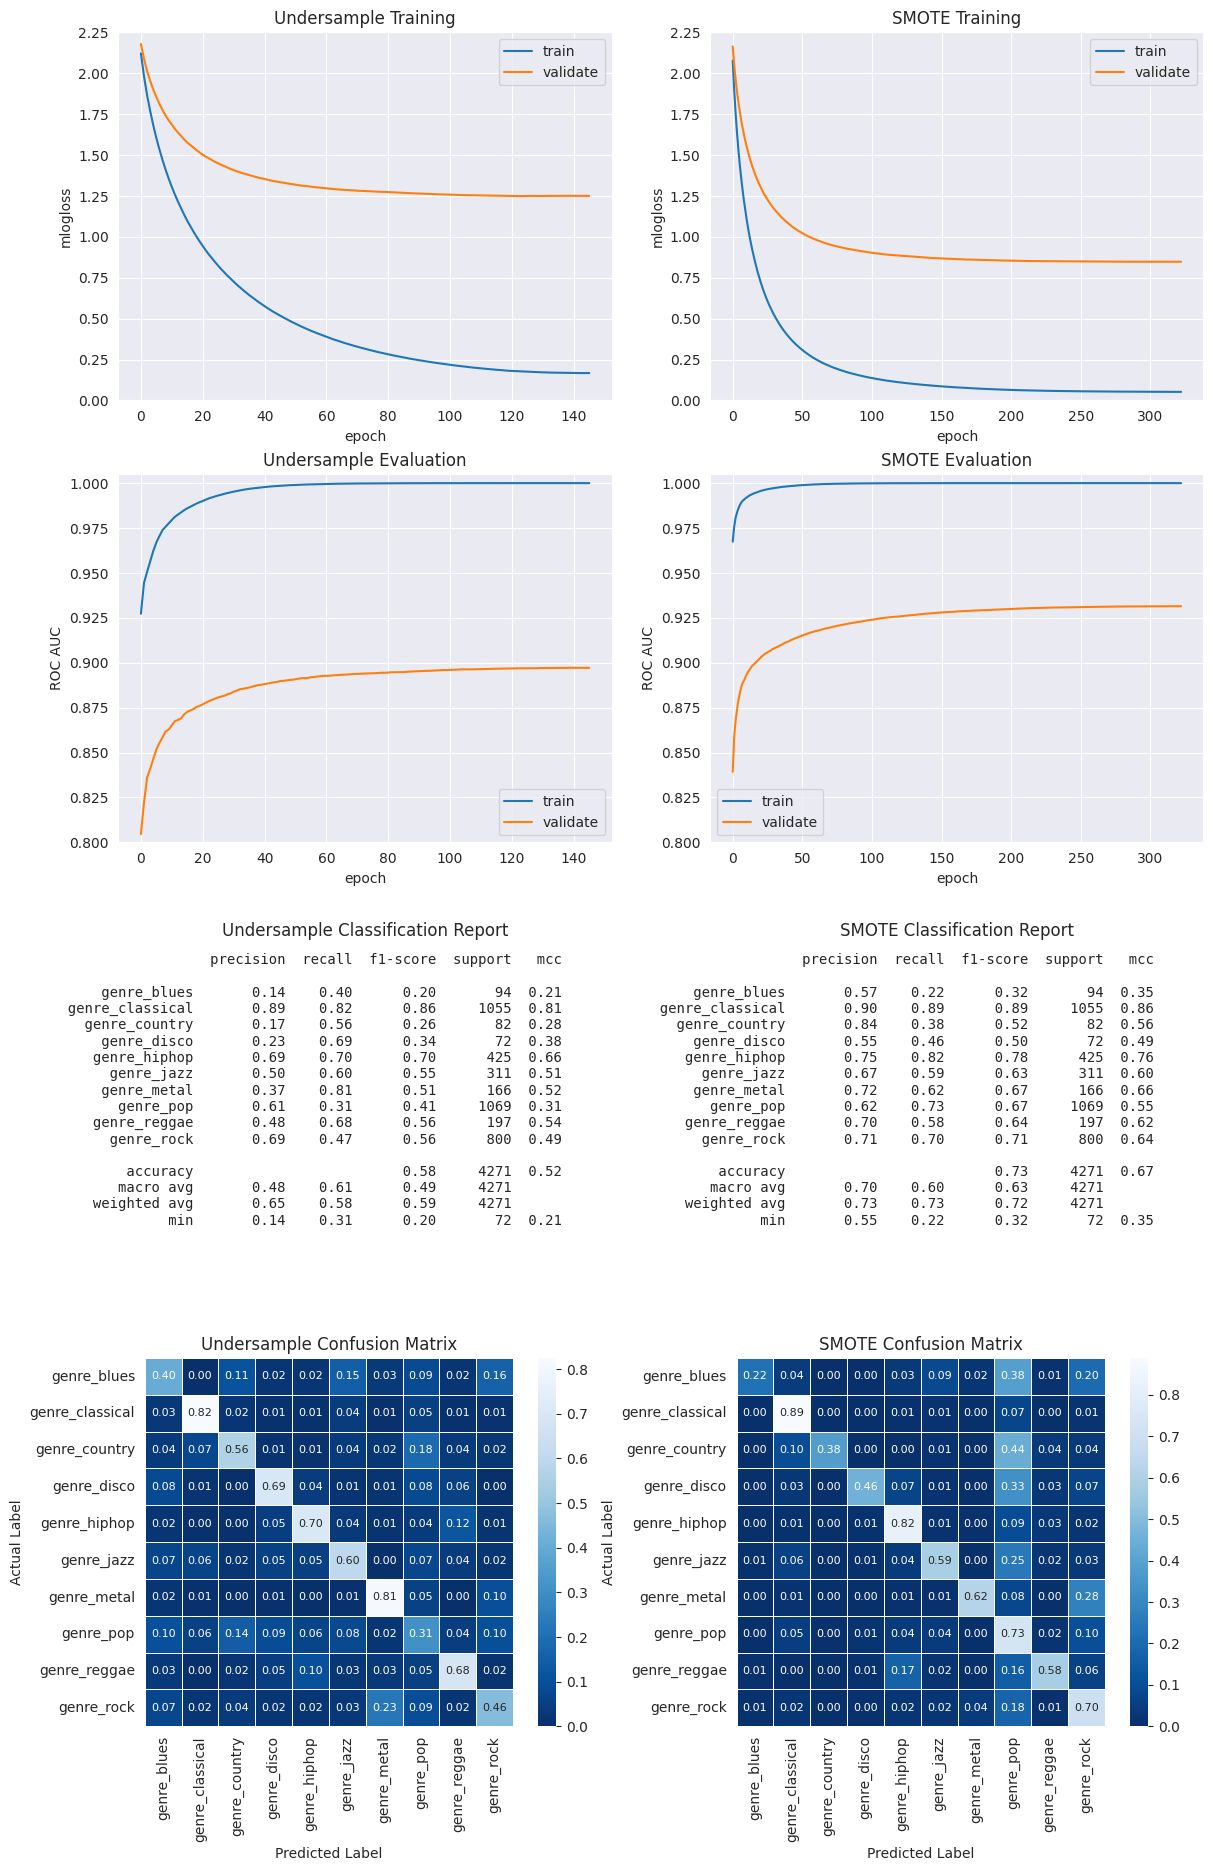

Undersample Method:
------------------
Test MCC: 0.5160317681199424
Test F1 Macro: 0.494153846972194
Test Balanced Accuracy: 0.6052067437041466

SMOTE Method:
------------
Test MCC: 0.6666069004793178
Test F1 Macro: 0.6319287173165946
Test Balanced Accuracy: 0.5984401928204628


In [53]:
xgboost_undersample_metrics = {
    'model_name': 'XGBoost Undersampled',
    'test_mcc':matthews_corrcoef(y_true_test, undersample_classifier_y_pred_test),
    'test_f1_macro':f1_score(y_true_test, undersample_classifier_y_pred_test, average='macro'),
    'test_balanced_accuracy':balanced_accuracy_score(y_true_test, undersample_classifier_y_pred_test)
}

xgboost_smote_metrics = {
    'model_name': 'XGBoost SMOTE',
    'test_mcc':matthews_corrcoef(y_true_test, smote_classifier_y_pred_test),
    'test_f1_macro':f1_score(y_true_test, smote_classifier_y_pred_test, average='macro'),
    'test_balanced_accuracy':balanced_accuracy_score(y_true_test, smote_classifier_y_pred_test)
}

make_notebook_undersampling_smote_classification_summary(
    y_true_test,
    undersample_classifier_y_pred_test,
    smote_classifier_y_pred_test,
    undersample_train_results,
    undersample_validation_results,
    smote_train_results,
    smote_validation_results,
    le=le
)

print('Undersample Method:')
print('------------------')
print(f"Test MCC: {xgboost_undersample_metrics['test_mcc']}")
print(f"Test F1 Macro: {xgboost_undersample_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {xgboost_undersample_metrics['test_balanced_accuracy']}")
print('\nSMOTE Method:')
print('------------')
print(f"Test MCC: {xgboost_smote_metrics['test_mcc']}")
print(f"Test F1 Macro: {xgboost_smote_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {xgboost_smote_metrics['test_balanced_accuracy']}")

___

**Model performance on test data**

The balanced accuracy scores of the two models are roughly equivalent to both each other, and our baseline and tuned logistic regression models. the SMOTE model outperforms the undersampled model on our test data with an improvement in the MCC score of roughly 0.15 and an improvement in macro average f1 of roughly 13%.    Nevertheless, when we look more closely at the differences, it is difficult to endorse the SMOTE model over the undersampled model.  The SMOTE model outperforms the undersampled model in only four of the ten genres, with the primary impact being in the pop and rock genres, where the SMOTE model dominates.  So the undersampling model outperforms the SMOTE model on our test data in six out of ten genres but the difference in performance in favor of the SMOTE model is much more meaningful in two categories, so much so that it lifts the model performance in the aggregate.  There is clearly more work to be done here.

---

## CNN on Mel Spectrograms with Data Imbalance

We also built a Convolutional Neural Net model using the mel spectrogram version of our dataset.  This dataset consists solely of the mel spectrogram representation of the audio being sampled without any additional feature extraction.

The samples in our dataset do not have a uniform length.  To address that and to manage the size, we exracted a thirty second segment from the middle of each sample.

We began with a simple random CNN model with one Conv2D layer and one MaxPool2D layer. This model performed poorly with accuracy hovering around 20%.  The loss curve was volative and difficult to tune.

The application of CNN to music genre classification is the topic of many research articles. We reviewed relevant literature to help us build our model.  We worked from the model described in [this article](https://towardsdatascience.com/music-genre-recognition-using-convolutional-neural-networks-cnn-part-1-212c6b93da76) to jump start our baseline CNN model. 

Unfortunately, using the center cropped 30s mel spectrogram dataset on the baseline model was not satisfactory. The loss curve suggested that the model need more sample data. By partitioning the center cropped 30 second data into 10 three second chunks, we significantly improved the model's performance.

In [39]:
def split10(array):
    return np.array_split(array[:, 0:680], 10, axis=1)


def partition(df, shuffle=True):
    df = df.copy()
    df["melspec"] = df["melspec"].apply(split10)
    df = df.explode(["melspec"]).reset_index(drop=True)
    if shuffle:
        df = df.sample(frac=1)  # shuffle

    return df


def transformData(X):
    # extract 2D numpy array from pandas dataframe
    X = np.array(list(X.to_numpy()[:, 0]))

    scaler = StandardScaler()
    # flatten 2D array to fit to "overall" mean / variance
    scaler.fit(X.reshape(-1, 1))
    # must be reshaped for transformation then restored to original shape
    X = scaler.transform(X.reshape(-1, 1)).reshape(X.shape)

    # add a dimension from (n, 96, 68) to (n, 96, 68, 1)
    X = np.expand_dims(X, axis=-1)

    return X

# this helper function generates a new data set from the melspecs data file
# by segmenting each song spectrogram into multiple data samples of smaller
# vertival slices
def same_prepare_process(df, balanced=False):
    df = partition(df)

    _, (y, le), X = tag_label_feature_split(df, label_format="encoded")

    if balanced:
        rus = RandomUnderSampler(random_state=1962)
        X, y = rus.fit_resample(X, y)

    X = transformData(X)

    X_train, X_test, y_train, y_test = make_train_test_split(
        X, y, test_size=0.2, random_state=1962, stratify=y
    )

    X_train, X_validation, y_train, y_validation = make_train_test_split(
        X_train, y_train, test_size=0.25, random_state=1962, stratify=y_train
    )

    class_weight = make_class_weight_dict(y_train,le)

    return (
        X_train,
        X_test,
        y_train,
        y_test,
        X_validation,
        y_validation,
        class_weight,
        le,
    )




### Imbalanced All Genres Dataset

In [40]:
# reading dataset

(
    X_melspec_10_imbalanced_train,
    X_melspec_10_imbalanced_test,
    y_melspec_10_imbalanced_train,
    y_melspec_10_imbalanced_test,
    X_melspec_10_imbalanced_validation,
    y_melspec_10_imbalanced_validation,
    class_weight,
    le,
) = same_prepare_process(df_melspec, balanced=False)


Lets build the model

In [41]:
def build_model(
    filters=[16, 32, 64, 128],
    kernal_size=[(3, 3), (3, 3), (3, 3), (3, 3)],
    strides=(1, 1),
    padding="same",
    activation="relu",
    pool_size=(2, 2),
    batch_axis=[3, 3, -1, -1],
    dropout_rate=[0.3, 0.3, 0.3, 0.3],
    input_shape=(None, 96, 68, 1),
    last_activation="softmax",
    genres=10,
):
    model = tf.keras.Sequential()

    for i in range(len(filters)):
        model.add(
            tf.keras.layers.Conv2D(
                filters=filters[i],
                kernel_size=kernal_size[i],
                strides=strides,
                padding=padding,
                name=f"conv_{i}",
                activation=activation,
            )
        )

        tf.keras.layers.BatchNormalization(batch_axis[i])

        model.add(tf.keras.layers.MaxPool2D(pool_size=pool_size, name=f"pool_{i}"))

        model.add(tf.keras.layers.Dropout(rate=dropout_rate[i], name=f"dropout_{i}"))

    model.add(tf.keras.layers.Flatten())

    model.add(
        tf.keras.layers.Dense(units=genres, name="fc_last", activation=last_activation)
    )

    tf.random.set_seed(1)
    model.build(input_shape=input_shape)
    print(model.summary())

    return model

In [42]:
cnn_model_imbalanced = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv2D)             (None, 96, 68, 16)        160       
                                                                 
 pool_0 (MaxPooling2D)       (None, 48, 34, 16)        0         
                                                                 
 dropout_0 (Dropout)         (None, 48, 34, 16)        0         
                                                                 
 conv_1 (Conv2D)             (None, 48, 34, 32)        4640      
                                                                 
 pool_1 (MaxPooling2D)       (None, 24, 17, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 17, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 17, 64)        1

In [43]:
learning_rate = 0.00055
epoch = 100

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate, decay_steps=50000, decay_rate=0.96,
)

cnn_model_imbalanced.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy", get_f1],
)

In [44]:
tf.random.set_seed(1234)
np.random.seed(1234)
hist = cnn_model_imbalanced.fit(
    X_melspec_10_imbalanced_train,
    y_melspec_10_imbalanced_train,
    epochs=epoch,
    validation_data=(X_melspec_10_imbalanced_validation, y_melspec_10_imbalanced_validation),
    class_weight=class_weight,
    verbose=0,
)

Accuracy and Loss Curves

After careful hyper parameter tuning in general, we found that neither L1 or L2 regularization helped with overfitting. Smaller learning rates helped.

In [45]:
def accuracy_and_loss_curve(hist):
    history = hist.history

    # plot loss for train and validation
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history["loss"], lw=2, color="darkgoldenrod")
    plt.plot(history["val_loss"], lw=2, color="indianred")
    plt.legend(["Train", "Validation"], fontsize=10)
    ax.set_xlabel("Epochs", size=10)
    ax.set_title("Loss")

    ax = fig.add_subplot(1, 3, 2)
    plt.plot(history["accuracy"], lw=2, color="darkgoldenrod")
    plt.plot(history["val_accuracy"], lw=2, color="indianred")
    plt.legend(["Train", "Validation"], fontsize=10)
    # plt.ylim(0.7,0.8)
    ax.set_xlabel("Epochs", size=10)
    ax.set_title("accuracy")
    plt.show()

    print(
        "After fine-tuning this model, evaluation on the validation data shows an accuracy of:",
        np.round(history["val_accuracy"][-1] * 100, 2),
        "%",
    )

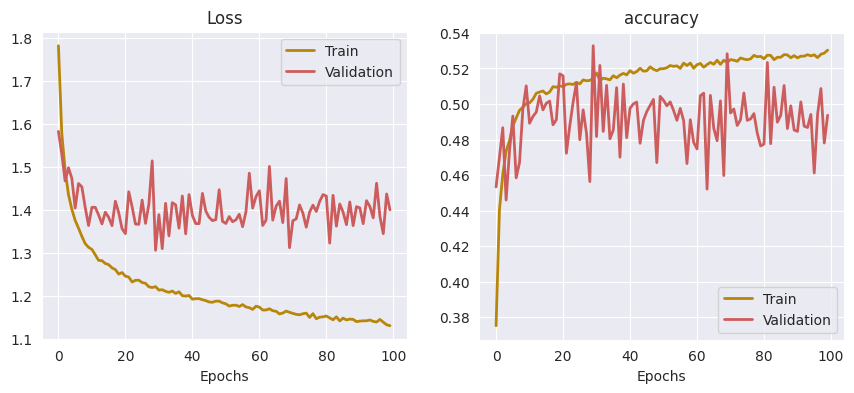

After fine-tuning this model, evaluation on the validation data shows an accuracy of: 49.37 %


In [46]:

accuracy_and_loss_curve(hist)


1335/1335 [==============================] - 3s 2ms/step


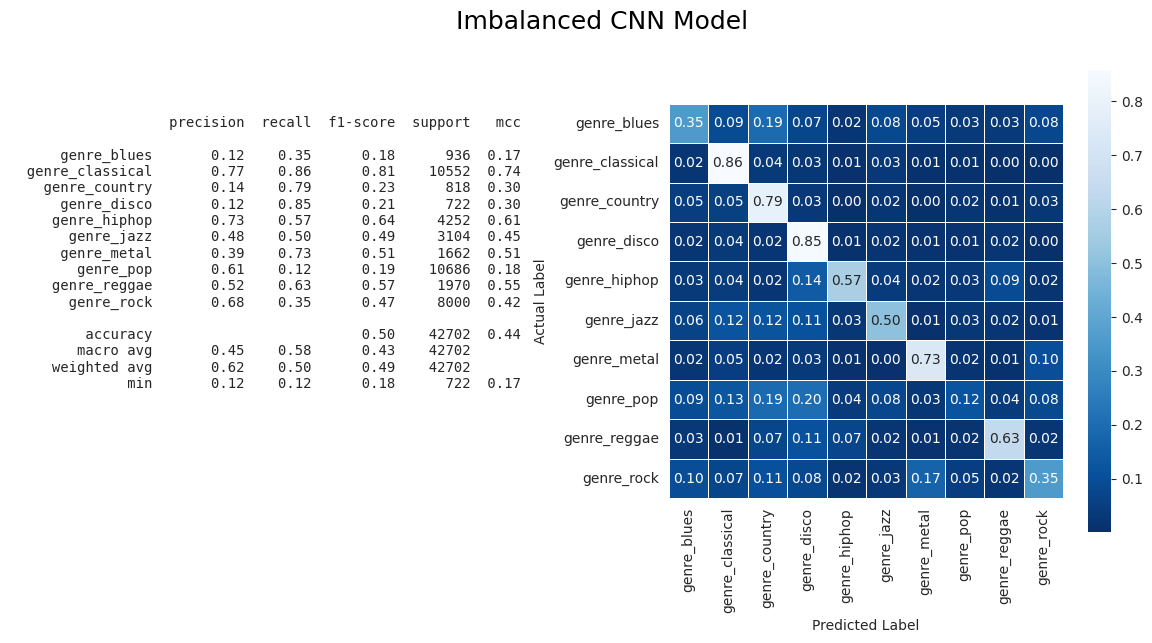

Imbalanced Data Method:
----------------------
Test MCC: 0.4428844634406507
Test F1 Macro: 0.42980473093250404
Test Balanced Accuracy: 0.5753115567330036


In [47]:
y_pred_melspec_10_imbalanced = cnn_model_imbalanced.predict(X_melspec_10_imbalanced_test)
y_pred_melspec_10_imbalanced = np.argmax(y_pred_melspec_10_imbalanced, axis=1)

make_classification_report(
    y_true=y_melspec_10_imbalanced_test,
    y_pred=y_pred_melspec_10_imbalanced,
    label_encoder=le,
    print_report=False,
)

make_notebook_classification_summary(y_melspec_10_imbalanced_test, y_pred_melspec_10_imbalanced, le=le, title="Imbalanced CNN Model")

cnn_imbalanced_metrics = {
    'model_name':'CNN Imbalanced Data',
    'test_mcc':matthews_corrcoef(y_melspec_10_imbalanced_test, y_pred_melspec_10_imbalanced),
    'test_f1_macro':f1_score(y_melspec_10_imbalanced_test, y_pred_melspec_10_imbalanced, average='macro'),
    'test_balanced_accuracy':balanced_accuracy_score(y_melspec_10_imbalanced_test, y_pred_melspec_10_imbalanced)
}

print('Imbalanced Data Method:')
print('----------------------')
print(f"Test MCC: {cnn_imbalanced_metrics['test_mcc']}")
print(f"Test F1 Macro: {cnn_imbalanced_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {cnn_imbalanced_metrics['test_balanced_accuracy']}")

pass

The resuling balanced accuracy has a 2% drop from our baseline and other models seen so far. The MCC drops by 0.08 relative to our baseline logistic regression model.

### Balanced All Genres Dataset (Under Sampling)

In [48]:
(
    X_melspec_10_balanced_train,
    X_melspec_10_balanced_test,
    y_melspec_10_balanced_train,
    y_melspec_10_balanced_test,
    X_melspec_10_balanced_validation,
    y_melspec_10_balanced_validation,
    class_weight,
    le,
) = same_prepare_process(df_melspec, balanced=True)

In [49]:
cnn_model_balanced = build_model(genres=10)
cnn_model_balanced.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy", get_f1],
)
hist = cnn_model_balanced.fit(
    X_melspec_10_balanced_train,
    y_melspec_10_balanced_train,
    epochs=epoch,
    validation_data=(X_melspec_10_balanced_validation, y_melspec_10_balanced_validation),
    class_weight=class_weight,
    verbose=0,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv2D)             (None, 96, 68, 16)        160       
                                                                 
 pool_0 (MaxPooling2D)       (None, 48, 34, 16)        0         
                                                                 
 dropout_0 (Dropout)         (None, 48, 34, 16)        0         
                                                                 
 conv_1 (Conv2D)             (None, 48, 34, 32)        4640      
                                                                 
 pool_1 (MaxPooling2D)       (None, 24, 17, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 17, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 17, 64)       

Lets examine the accuracy and loss curve again

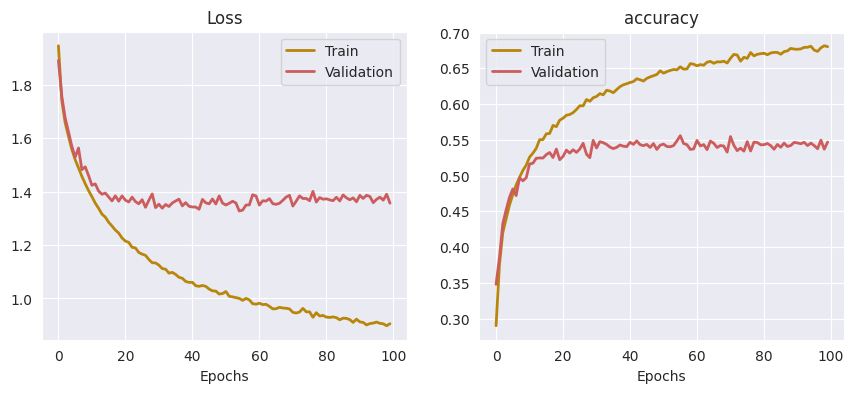

After fine-tuning this model, evaluation on the validation data shows an accuracy of: 54.7 %


In [50]:
accuracy_and_loss_curve(hist)

226/226 [==============================] - 1s 2ms/step


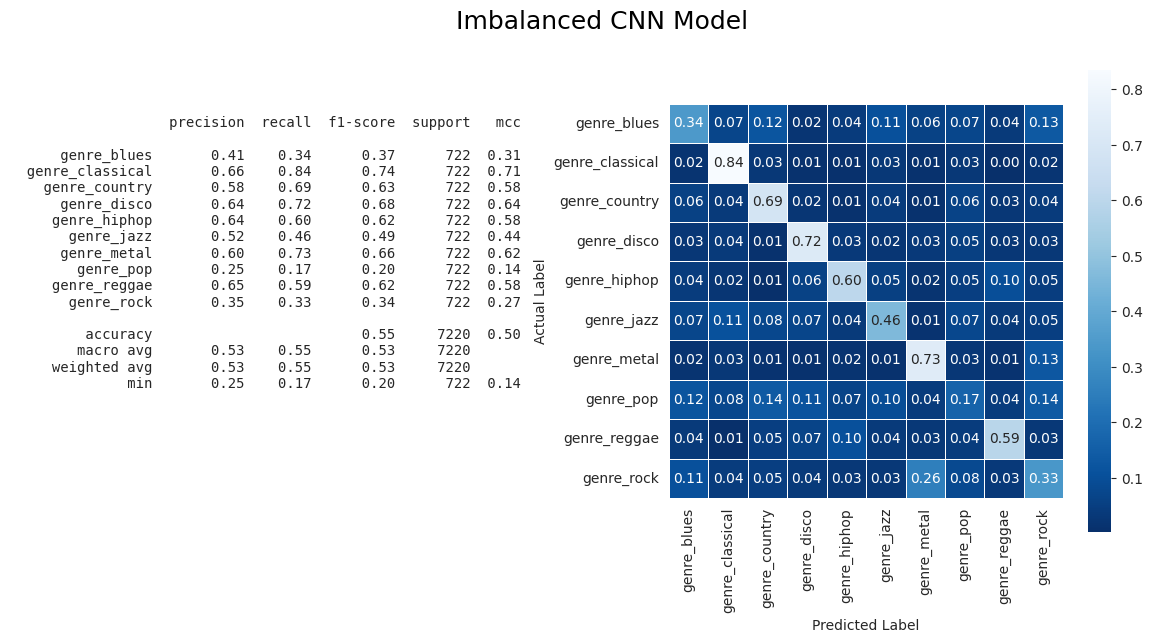

Imbalanced Data Method:
----------------------
Test MCC: 0.49830932722819654
Test F1 Macro: 0.5347026905953252
Test Balanced Accuracy: 0.5476454293628809

(Imbalanced Data Method again for reference):
--------------------------------------------
Test MCC: 0.4428844634406507
Test F1 Macro: 0.42980473093250404
Test Balanced Accuracy: 0.5753115567330036


In [52]:
y_pred_melspec_10_balanced = cnn_model_balanced.predict(X_melspec_10_balanced_test)
y_pred_melspec_10_balanced = np.argmax(y_pred_melspec_10_balanced, axis=1)
make_classification_report(
    y_true=y_melspec_10_balanced_test,
    y_pred=y_pred_melspec_10_balanced,
    label_encoder=le,
    print_report=False,
)

make_notebook_classification_summary(y_melspec_10_balanced_test, y_pred_melspec_10_balanced, le=le, title="Imbalanced CNN Model")

cnn_balanced_metrics = {
    'model_name':'CNN Balanced Data',
    'test_mcc':matthews_corrcoef(y_melspec_10_balanced_test, y_pred_melspec_10_balanced),
    'test_f1_macro':f1_score(y_melspec_10_balanced_test, y_pred_melspec_10_balanced, average='macro'),
    'test_balanced_accuracy':balanced_accuracy_score(y_melspec_10_balanced_test, y_pred_melspec_10_balanced)
}

print('Imbalanced Data Method:')
print('----------------------')
print(f"Test MCC: {cnn_balanced_metrics['test_mcc']}")
print(f"Test F1 Macro: {cnn_balanced_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {cnn_balanced_metrics['test_balanced_accuracy']}")

print('\n(Imbalanced Data Method again for reference):')
print('--------------------------------------------')
print(f"Test MCC: {cnn_imbalanced_metrics['test_mcc']}")
print(f"Test F1 Macro: {cnn_imbalanced_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {cnn_imbalanced_metrics['test_balanced_accuracy']}")
pass

The balanced accuracy drops to ~54%, though the MCC improves by ~0.07, relative to the unbalanced data CNN model. However, both models continue to have poor performance relative to the baseline logistic regression model. One interesting observation is the training accuracy and loss curve volatility improved.

# Summary of Results

In [68]:
summary_metrics = pd.DataFrame(np.array([
    np.array([
        m['model_name'],
        round(m['test_mcc'],2),
        round(m['test_f1_macro'],2),
        round(m['test_balanced_accuracy'],2)
    ])
    for m in [
        baseline_regression_metrics,
        tuned_baseline_regression_metrics,
        svc_no_pca_metrics,
         svc_pca_metrics,
        xgboost_undersample_metrics,
        xgboost_smote_metrics,
        cnn_balanced_metrics,
        cnn_imbalanced_metrics
    ]
]),columns=['Model Name','MCC','F1 Macro','Balanced Accuracy'])

summary_metrics.sort_values(by=['MCC'],ascending=False)

Model Name   MCC F1 Macro Balanced Accuracy
5                 XGBoost SMOTE  0.67     0.63               0.6
3                  SVM with PCA  0.66     0.62              0.56
2                    SVM No PCA  0.65     0.62              0.55
1     Tuned Logistic Regression  0.58     0.55              0.63
0  Baseline Logistic Regression  0.52     0.49              0.59
4          XGBoost Undersampled  0.52     0.49              0.61
6             CNN Balanced Data   0.5     0.53              0.55
7           CNN Imbalanced Data  0.44     0.43              0.58

Looking back at our results, XGBoost with SMOTE achieved the best MCC of 0.67, as well as the best F1 score of 0.63. Our tuned logistic regression model achieved the best balanced accuracy at 63%.

That said, most of these models performed relatively similarly, and none of them performed at a level that would inspire confidence in deploying in a production environment.

Below we discuss the limitations that lead be believe contributed to these modest results, and next steps that could make sense for further improvement.

# Limitations

## The Data Set

Despite trying many different model types with different parameters and approached, many not even making the cut for this notebook, the results were similar, and we believe we are ultimately limited by the dataset. We break down these limitations as follows:

### Data Imbalance

Despite trying to accommodate for data imbalance using methods like Undersampling and SMOTE, these methods are no substitute for the real thing.

### Quality of tagging

As a crowdsourced dataset, it is biased by its contributors. Certain less popular genres in modern times, e.g. Blues & Disco, performed poorly even when the data was balanced using undersampling. We wonder if these songs were more likely to be miscategorized. 

We hypothesize that the "Pop" genre, furthered by its massive size, is a dumping grounds for most music that didn't fit neatly into another genre. Pop is also a partiularly difficult genre because the definition for it (and to a lesser degree Rock), has changed from decade to decade. Because of this, it is populated by an exceptionally diverse collection of songs, meaning the "least common denominor" across all of them is limited.

We performed an experiment to test this theory by omitting the Pop genre from our dataset and running it through our CNN model:


In [56]:
# reading no-pop dataset file
df_melspec_no_pop = pd.read_pickle(os.path.join(DATASET_FOLDER,  "dataset_10_melspecs_no_pop.pickle"))

In [61]:
(
    X_melspec_10_no_pop_train,
    X_melspec_10_no_pop_test,
    y_melspec_10_no_pop_train,
    y_melspec_10_no_pop_test,
    X_melspec_10_no_pop_validation,
    y_melspec_10_no_pop_validation,
    class_weight,
    le_no_pop,
) = same_prepare_process(df_melspec_no_pop, balanced=True)

In [62]:
cnn_model_no_pop = build_model(genres=9)
cnn_model_no_pop.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy", get_f1],
)
hist = cnn_model_no_pop.fit(
    X_melspec_10_no_pop_train,
    y_melspec_10_no_pop_train,
    epochs=epoch,
    validation_data=(X_melspec_10_no_pop_validation, y_melspec_10_no_pop_validation),
    class_weight=class_weight,
    verbose=0,
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv2D)             (None, 96, 68, 16)        160       
                                                                 
 pool_0 (MaxPooling2D)       (None, 48, 34, 16)        0         
                                                                 
 dropout_0 (Dropout)         (None, 48, 34, 16)        0         
                                                                 
 conv_1 (Conv2D)             (None, 48, 34, 32)        4640      
                                                                 
 pool_1 (MaxPooling2D)       (None, 24, 17, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 17, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 17, 64)       

Lets examine the accuracy and loss curve again

204/204 [==============================] - 1s 2ms/step


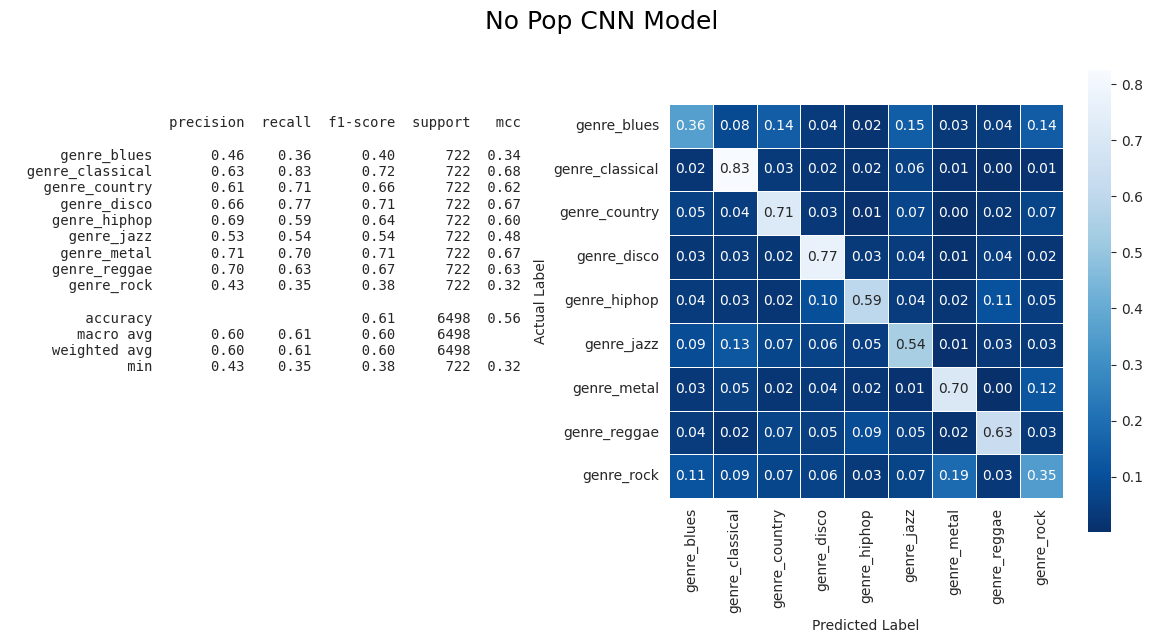

Balance No-Pop Data Method:
----------------------
Test MCC: 0.5612857413680207
Test F1 Macro: 0.6015269042261943
Test Balanced Accuracy: 0.6091104955370884
n\(Balanced All Genres again for reference):
------------------------------------------
Test MCC: 0.49830932722819654
Test F1 Macro: 0.5347026905953252
Test Balanced Accuracy: 0.5476454293628809


In [65]:
y_pred_melspec_10_no_pop = cnn_model_no_pop.predict(X_melspec_10_no_pop_test)
y_pred_melspec_10_no_pop = np.argmax(y_pred_melspec_10_no_pop, axis=1)

make_classification_report(
    y_true=y_melspec_10_no_pop_test,
    y_pred=y_pred_melspec_10_no_pop,
    label_encoder=le_no_pop,
    print_report=False,
)

make_notebook_classification_summary(y_melspec_10_no_pop_test, y_pred_melspec_10_no_pop, le=le_no_pop, title="No Pop CNN Model")


cnn_no_pop_metrics = {
    'test_mcc':matthews_corrcoef(y_melspec_10_no_pop_test, y_pred_melspec_10_no_pop),
    'test_f1_macro':f1_score(y_melspec_10_no_pop_test, y_pred_melspec_10_no_pop, average='macro'),
    'test_balanced_accuracy':balanced_accuracy_score(y_melspec_10_no_pop_test, y_pred_melspec_10_no_pop)
}

print('Balance No-Pop Data Method:')
print('----------------------')
print(f"Test MCC: {cnn_no_pop_metrics['test_mcc']}")
print(f"Test F1 Macro: {cnn_no_pop_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {cnn_no_pop_metrics['test_balanced_accuracy']}")

print('n\(Balanced All Genres again for reference):')
print('------------------------------------------')
print(f"Test MCC: {cnn_balanced_metrics['test_mcc']}")
print(f"Test F1 Macro: {cnn_balanced_metrics['test_f1_macro']}")
print(f"Test Balanced Accuracy: {cnn_balanced_metrics['test_balanced_accuracy']}")
pass

In this CNN model, just by removing pop, we see a ~6-point improvement across all three performance metrics we've been using, relative to the balanced data model with pop still included.


# Future Exploration

## Ensembles

We observed that certain models performed better for different genres, and think that in concert they could do a more adequate job at genre identification. We're hesitent to believe that a traditional "voting" method would be sufficient in itself based on the confusion matrices we've seen, however wonder if success could be found using a FFNN as a pseudo-ensemble model where the `y_pred`, either pre or post `argmax` where available, from each primary could serve as the "features", and the same `y_true` as the FFNN's training labels. We could be interested to see if it could find unusual patterns that aren't first observable with the naked eye. E.g.: If SVM predicts the song is jazz, and XGBoost predicts a song is Disco, then in fact the song is likely Reggae.

## Humanizing the process

Humans define genres based on things like instruments used, time signatures, lyrics and speech dialect. Because of this, it may be a tough ask for algorithms to make the direct jump from abstract spectral measurements to genre prediction.

We hypothesize that creating a collection of models, eached designed to solely to detect one of these human-defined features could have more success with correct predictions. From there, an ensemble model, perhaps one similar to described above, could have the sole task of making the secondary jump from human-features to genre prediction.

## Not treating genres as classes

Genres aren't discrete and mutually exclusive to each other. Genre is a convenient concise way to describe a song, however much of music lives on the borders between two or more genres.

Because of this, not all misclassifications are equal. A misclassification of blues as rock is not an equivalent failure to misclassifying a classical song as hip hop. We wonder if there are optimizers that could account for this.

Alternatively, we wonder if better results could be found by treating a genre as a set of coordinates in a multidimensional space rather than an independent class, that accurately encapsulates their relationship to each other. As we discussed at the beginning of the notebook, many songs were tagged with multiple genres. We speculate that these could be used to derive the common relations between different genres. Perhaps using something like embedding could create an N-Dimensional definition of each genre. These could then be used in place of classes as the labels for machine learning models. The nearest neighboring genre to the coordinates predicted by the model could be deemed the predicted genre.